In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Note: colab has changed the tensorflow version from 27 March 2020
#General
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import glob
import seaborn
from datetime import datetime
import numpy as np
import itertools
import os, fnmatch
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.preprocessing import StandardScaler

# Audio
import librosa.display, librosa
from librosa.util import normalize as normalize
import IPython.display as ipd

In [ ]:
  # Signal Processing Parameters
  fs = 44100         # Sampling Frequency
  n_fft = 2048      # length of the FFT window
  hop_length = 812   # Number of samples between successive frames
  testset_size = 0.25 # Percentage of data for Testing

**Nvidia**

In [ ]:
# This code snippent converts the raw audio files into spectrogram numpy array in bulk

def BatchConvertAudioToNumpy(file_path):
  n_fft = 2048
  hop_length = 512
  y, sr = librosa.load(file_path)
  y = normalize(y)
  y = librosa.util.fix_length(y, 61000)
  spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2
  data = librosa.power_to_db(spectrogram_librosa, ref=np.max)
  # librosa.db_to_power(spectrogram_librosa, ref=np.max)
  # librosa.display.specshow(data, sr=fs) # to display the spectrogram
  # data  = np.expand_dims(data, axis=0)
  data  = np.expand_dims(data, axis=2)
  return data

def generateDataAndLabelForCNN(dir_path):
  labels = []
  feature_vectors = []
  for paths, subdirs, files in os.walk(dir_path):
    for name in files:
      feature_vectors.append(BatchConvertAudioToNumpy(os.path.join(paths, name)))
      splitting = paths.split("/")
      if splitting[7] == "N_aug":
        labels.append(0)
      elif splitting[7] == "AS_aug":
        labels.append(1)
      elif splitting[7] == "MR_aug":
        labels.append(2)
      elif splitting[7] == "MS_aug":
        labels.append(3)
      elif splitting[7] == "MVP_aug":
        labels.append(4)
  return np.array(labels), np.array(feature_vectors)

In [ ]:
path_as  = "/content/drive/MyDrive/datasets/cardio/dataset-1/AS_New/New_AS_001.wav"
path_mr  = "/content/drive/MyDrive/datasets/cardio/dataset-1/MR_New/New_MR_001.wav"
path_ms  = "/content/drive/MyDrive/datasets/cardio/dataset-1/MS_New/New_MS_001.wav"
path_mvp = "/content/drive/MyDrive/datasets/cardio/dataset-1/MVP_New/New_MVP_001.wav"
path_n   = "/content/drive/MyDrive/datasets/cardio/dataset-1/N_New/New_N_001.wav"


In [ ]:
# Trim Silence and Recalculate Duration Load audio files, trim silence and calculate duration
# duration = []
    
y, sr = librosa.load(path_n, sr = fs)  # The sample rate sr: which means how many samples are recorded per second.
# yt, index = librosa.effects.trim(y,top_db=60) #Trim
duration = librosa.get_duration(y, sr=fs)
        
print("Calculated %d Durations", duration)
# print("Toral files are", i)

Calculated %d Durations 2.104625850340136


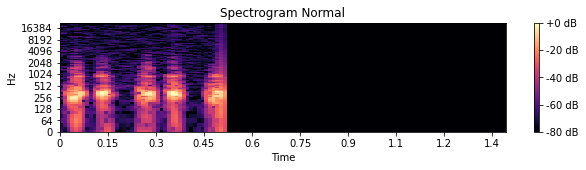

In [ ]:
aug_path_as  = "/content/drive/MyDrive/datasets/cardio/dataset-1_aug/AS_aug/aug_AS_001.wav"
aug_path_mr  = "/content/drive/MyDrive/datasets/cardio/dataset-1_aug/MR_aug/aug_MR_001.wav"
aug_path_ms  = "/content/drive/MyDrive/datasets/cardio/dataset-1_aug/MS_aug/aug_MS_001.wav"
aug_path_mvp = "/content/drive/MyDrive/datasets/cardio/dataset-1_aug/MVP_aug/aug_MVP_001.wav"
aug_path_n   = "/content/drive/MyDrive/datasets/cardio/dataset-1_aug/N_aug/aug_N_001.wav"

def draw_spectrogram(file_path):
  n_fft = 2048
  hop_length = 512
  y, sr = librosa.load(file_path)
  y = normalize(y)
  y = librosa.util.fix_length(y, 61000)
  spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2
  data = librosa.power_to_db(spectrogram_librosa, ref=np.max)

  plt.figure(figsize = (10, 2))
  plt.title("Spectrogram Normal")
  librosa.display.specshow(data, sr=fs, y_axis='log', x_axis='time')
  plt.colorbar(format = '%+2.0f dB')

draw_spectrogram(aug_path_n)

In [ ]:
# after generating the numpy data, test dataset folders are included to make full dataset
start = datetime.now()
labels, feature_vector = generateDataAndLabelForCNN("/content/drive/MyDrive/datasets/cardio/dataset-1_aug")
print("Conversion time is: ", datetime.now() - start)
print(labels.shape, " ", feature_vector.shape)

Conversion time is:  0:08:56.508829
(1000,)   (1000, 1025, 120, 1)


In [ ]:
# saving new labels and feature vector
np.save('/content/drive/My Drive/saved_arrays/X_aug_cardio_dataset_1.npy', feature_vector)
np.save('/content/drive/My Drive/saved_arrays/y_aug_cardio_dataset_1.npy', labels)

**Feature vector and label generator**

In [ ]:
# This code snippent converts the raw audio files into spectrogram numpy array in bulk
# old function
def BatchConvertAudioToNumpy(file_path):
  y, sr = librosa.load(file_path, sr=fs)
  y, index = librosa.effects.trim(y,top_db=60) # Trim
  y = normalize(y)
  duration_in_samples = librosa.time_to_samples(1, sr=fs)
  y_pad = librosa.util.fix_length(y, duration_in_samples)
  y_stft= librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
  y_spec= librosa.amplitude_to_db(abs(y_stft), np.min)
  scaler= StandardScaler()
  dtype = K.floatx()
  data  = scaler.fit_transform(y_spec).astype(dtype)
  # data  = np.expand_dims(data, axis=0)
  data  = np.expand_dims(data, axis=2)
  # librosa.display.specshow(y_spec, sr=fs) # to display the spectrogram
  return data

def generateDataAndLabelForCNN(dir_path):
  labels = []
  feature_vectors = []
  for paths, subdirs, files in os.walk(dir_path):
    for name in files:
      feature_vectors.append(BatchConvertAudioToNumpy(os.path.join(paths, name)))
      splitting = paths.split("/")
      if splitting[7] == "N_aug":
        labels.append(0)
      elif splitting[7] == "AS_aug":
        labels.append(1)
      elif splitting[7] == "MR_aug":
        labels.append(2)
      elif splitting[7] == "MS_aug":
        labels.append(3)
      elif splitting[7] == "MVP_aug":
        labels.append(4)
  return np.array(labels), np.array(feature_vectors)

In [ ]:
# after generating the numpy data, test dataset folders are included to make full dataset
start = datetime.now()
labels, feature_vector = generateDataAndLabelForCNN("/content/drive/MyDrive/datasets/cardio/dataset-1")
print("Conversion time is: ", datetime.now() - start)
print(labels.shape, " ", feature_vector.shape)

Conversion time is:  0:07:12.047784
(1000,)   (1000, 1025, 55, 1)


In [ ]:
# after generating the numpy data, test dataset folders are included to make full dataset
start = datetime.now()
labels, feature_vector = generateDataAndLabelForCNN("/content/drive/MyDrive/datasets/cardio/dataset-1_aug")
print("Conversion time is: ", datetime.now() - start)
print(labels.shape, " ", feature_vector.shape)

In [ ]:
# saving new labels and feature vector
np.save('/content/drive/My Drive/saved_arrays/cardio_dataset_1_aug_labels.npy', labels)
np.save('/content/drive/My Drive/saved_arrays/cardio_dataset_1_aug_feature_vector.npy', feature_vector)

**Spectogram and numpy conversion functions**

In [ ]:
# loading the files and labels

# For binary
# path_h = '/content/drive/My Drive/datasets/dysphasia/Healthy/*/*/*.wav'
# path_d = '/content/drive/My Drive/datasets/dysphasia/Patients/*/*/*.wav'
# filename_h = [file for file in glob.glob(path_h)]
# filename_d = [file for file in glob.glob(path_d)]
# label_h = [0] * len(filename_h)
# label_d = [1] * len(filename_d)
# files = filename_h + filename_d
# labels = label_h + label_d
# classes_num = labels

# For multiclass
path = '/content/drive/MyDrive/datasets/cardio/dataset-1/*/*.wav'
filename = [file for file in glob.glob(path)]
print(len(filename))

1000


/content/drive/MyDrive/datasets/cardio/dataset-1/AS_New/New_AS_001.wav
Spectogram Array Shape: (1025, 87)


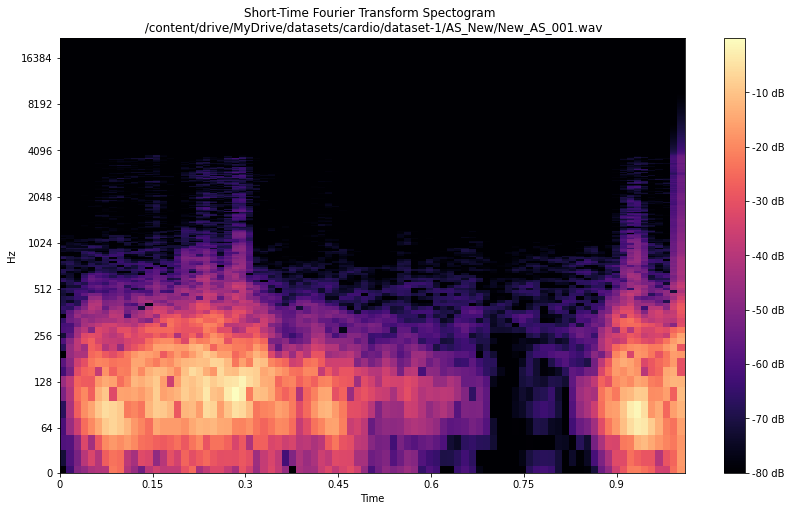

In [ ]:
# STFT Example for single file only, testing purpose only

# file = filename[999]
file = '/content/drive/MyDrive/datasets/cardio/dataset-1/AS_New/New_AS_001.wav'
print(file)
y, sr = librosa.load(file, sr=fs, duration=1)
y/=y.max() # Normalize
duration_in_samples=librosa.time_to_samples(1, sr=fs)
y_pad = librosa.util.fix_length(y, duration_in_samples) # Pad to 1s if smaller
y_stft= librosa.core.stft(y_pad, n_fft=n_fft, hop_length = hop_length)
y_spec= librosa.amplitude_to_db(abs(y_stft), np.max)

plt.figure(figsize = (14,8))
plt.title("Short-Time Fourier Transform Spectogram \n %s"%file)
librosa.display.specshow(y_spec, sr=fs, y_axis='log', x_axis='time')
plt.colorbar(format = '%+2.0f dB')
print("Spectogram Array Shape:", y_spec.shape)
ipd.Audio(y, rate = fs)

In [ ]:
file = filename[1]
y, sr = librosa.load(file, sr=fs, duration=1)
ipd.Audio(y, rate = fs)

/usr/local/lib/python3.6/dist-packages/IPython/lib/display.py:135: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()


In [ ]:
# for keras Generator function, direct fed in model training

def featureGenerator(files, labels):
    while True:
        for i,f in enumerate(files):
            try:
                feature_vectors = []
                label = []
                y, sr = librosa.load(f, sr=fs)
                
                if len(y) < 2:
                    print("Error loading %s" % f)
                    continue
                
                y, index = librosa.effects.trim(y,top_db=60) # Trim
                y = normalize(y)
                duration_in_samples = librosa.time_to_samples(1, sr=fs)
                y_pad = librosa.util.fix_length(y, duration_in_samples) # Pad/Trim to same duration
                y_stft= librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
                y_spec= librosa.amplitude_to_db(abs(y_stft), np.min)
                scaler= StandardScaler()
                dtype = K.floatx()
                data  = scaler.fit_transform(y_spec).astype(dtype)
                data  = np.expand_dims(data, axis=0)
                data  = np.expand_dims(data, axis=3)
                feature_vectors.append(data)
                label.append([labels[i]])
                yield feature_vectors, label
            except Exception as e:
                print("Error loading %s. Error: %s" % (f,e))
                raise
                break

**Functions for pedcition of age group audios and other utility functions**

In [ ]:
# Spectrogram generator for audio file

def ConvertAudioToNumpy(file_path):
    y, sr = librosa.load(file_path, sr=fs)
    y, index = librosa.effects.trim(y,top_db=60) # Trim
    y = normalize(y)
    duration_in_samples = librosa.time_to_samples(1, sr=fs)
    y_pad = librosa.util.fix_length(y, duration_in_samples) # Pad/Trim to same duration
    y_stft= librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
    y_spec= librosa.amplitude_to_db(abs(y_stft), np.min)
    scaler= StandardScaler()
    dtype = K.floatx()
    data  = scaler.fit_transform(y_spec).astype(dtype)
    data  = np.expand_dims(data, axis=0)
    data  = np.expand_dims(data, axis=3)
    # librosa.display.specshow(y_spec, sr=fs) # to display the spectrogram
    return data

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras.

In [ ]:
# from keras.models import load_model
from tensorflow.keras.models import load_model
modelPath = "/content/drive/MyDrive/saveModels/dysphasia/4.2_fold_1.hdf5"
model = load_model(modelPath)

In [ ]:
# probability prediction functions

def predict_class(audio_file_path):
  output = ConvertAudioToNumpy(audio_file_path)
  prob = model.predict(output)[0]*100
  # if np.argmax(prob) == 0:
  #   print("Healthy with probability ", prob[0], "%")
  # else:
  #   print("Dysphasia with probability ", prob[1], "%")
  return np.argmax(prob)


def dysphasia_prediction(path):
    healthy_count = 0
    dysphasia_count = 0
    count_files = 0
    for paths, subdirs, files in os.walk(path):
        for name in files:
            if name[-4:] == ".wav": # if extension is .wav
                x = os.path.join(paths, name)
                if os.path.exists(x):
                  if predict_class(x) == 0:
                    healthy_count +=1
                  else:
                    dysphasia_count +=1
                  count_files += 1
                else:
                  print("The file does not exist")
    print("--------------------------------")
    print(healthy_count, " Healthy predictions and ", dysphasia_count, "Dysphasia predictions.")
    print("Total ", count_files, "files has perdicted \n")

In [ ]:
# Age group prediction function

def age_grp_prediction(path, range_1, range_2):
  filename = [file for file in glob.glob(path)]
  filename.sort()
  new_list = []
  for i in filename:
    if int(i[-2:]) in range(range_1, range_2+1):
      new_list.append(i)
  start_time = datetime.now()
  for i in new_list:
    print("************ \n Folder",i[-3:],"\n************")
    dysphasia_prediction(i)
  print(f'Total Prediction time is {datetime.now() - start_time}')

In [ ]:
# Vowels, Consonants and Syllable prediction funtion for different age groups

# from keras.models import load_model
from tensorflow.keras.models import load_model
start_time = datetime.now()
modelPath = "/content/drive/MyDrive/saveModels/dysphasia/4.2_fold_10.hdf5"
model = load_model(modelPath)
print(f'Model loading time is {datetime.now() - start_time}')

def predict_class(audio_file_path):
  output = ConvertAudioToNumpy(audio_file_path)
  prob = model.predict(output)[0]*100
  return np.argmax(prob)

def groupwise_VowConsAndSyllablePrediction(rh1, rh2, rp1, rp2):
  path = "/content/drive/MyDrive/datasets/dysphasia"
  vocal_total, consonant_total, sl_1_total, sl_2_total, sl_3_total, sl_4_total, sl_5_total = 0, 0, 0, 0, 0, 0, 0
  vocal_correct, consonant_correct, sl_1_correct, sl_2_correct, sl_3_correct, sl_4_correct, sl_5_correct = 0, 0, 0, 0, 0, 0, 0
  for paths, subdirs, files in os.walk(path):
      for name in files:
          if name[-4:] == ".wav": # if extension is .wav
              x = os.path.join(paths, name)
              splitting = paths.split("/")
              H_P, folder_num, vcs_num = splitting[6], splitting[7][1:3], splitting[8][:2]
              if os.path.exists(x):
                if (int(folder_num) in range(rh1, rh2+1) and H_P == "Healthy") or (int(folder_num) in range(rp1, rp2+1) and H_P == "Patients"):
                  if H_P == "Healthy":
                    if vcs_num == "01":
                      vocal_total += 1
                      if predict_class(x) == 0:
                        vocal_correct += 1
                    if vcs_num == "02":
                      consonant_total += 1
                      if predict_class(x) == 0:
                        consonant_correct += 1
                    if vcs_num == "03":
                      sl_1_total += 1
                      if predict_class(x) == 0:
                        sl_1_correct += 1
                    if vcs_num == "04":
                      sl_2_total += 1
                      if predict_class(x) == 0:
                        sl_2_correct += 1
                    if vcs_num == "05":
                      sl_3_total += 1
                      if predict_class(x) == 0:
                        sl_3_correct += 1
                    if vcs_num == "06":
                      sl_4_total += 1
                      if predict_class(x) == 0:
                        sl_4_correct += 1
                    if vcs_num == "07":
                      sl_5_total += 1
                      if predict_class(x) == 0:
                        sl_5_correct += 1
                  elif H_P == "Patients":
                    if vcs_num == "01":
                      vocal_total += 1
                      if predict_class(x) == 1:
                        vocal_correct += 1
                    if vcs_num == "02":
                      consonant_total += 1
                      if predict_class(x) == 1:
                        consonant_correct += 1
                    if vcs_num == "03":
                      sl_1_total += 1
                      if predict_class(x) == 1:
                        sl_1_correct += 1
                    if vcs_num == "04":
                      sl_2_total += 1
                      if predict_class(x) == 1:
                        sl_2_correct += 1
                    if vcs_num == "05":
                      sl_3_total += 1
                      if predict_class(x) == 1:
                        sl_3_correct += 1
                    if vcs_num == "06":
                      sl_4_total += 1
                      if predict_class(x) == 1:
                        sl_4_correct += 1
                    if vcs_num == "07":
                      sl_5_total += 1
                      if predict_class(x) == 1:
                        sl_5_correct += 1

  print(f"vocal acc {(vocal_correct/vocal_total)*100}")
  print(f"consonant acc {(consonant_correct/consonant_total)*100}")
  print(f"sl_1 acc {(sl_1_correct/sl_1_total)*100}")
  print(f"sl_2 acc {(sl_2_correct/sl_2_total)*100}")
  print(f"sl_3 acc {(sl_3_correct/sl_3_total)*100}")
  print(f"sl_4 acc {(sl_4_correct/sl_4_total)*100}")
  print(f"sl_5 acc {(sl_5_correct/sl_5_total)*100} \n")
  print(vocal_total, consonant_total, sl_1_total, sl_2_total, sl_3_total, sl_4_total, sl_5_total)
  print(vocal_correct, consonant_correct, sl_1_correct, sl_2_correct, sl_3_correct, sl_4_correct, sl_5_correct)

# start_time = datetime.now()
# groupwise_VowConsAndSyllablePrediction(67, 69, 59, 61) # (67, 69, 59, 61)
# print(f'Total Prediction time is {datetime.now() - start_time}')

Model loading time is 0:00:03.546308


In [ ]:
# only for single file predictiona and time taking 

from tensorflow.keras.models import load_model
start_time = datetime.now()
modelPath = "/content/drive/MyDrive/saveModels/dysphasia/4.2_fold_2.hdf5"
model = load_model(modelPath)
print(f'Model loading time is {datetime.now() - start_time}')

# Spectrogram generator for audio file
def ConvertAudioToNumpy_for_cloud(file_path):
  start_time = datetime.now()
  y, sr = librosa.load(file_path, sr=fs)
  y, index = librosa.effects.trim(y,top_db=60) # Trim
  y = normalize(y)
  duration_in_samples = librosa.time_to_samples(1, sr=fs)
  y_pad = librosa.util.fix_length(y, duration_in_samples) # Pad/Trim to same duration
  y_stft= librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
  y_spec= librosa.amplitude_to_db(abs(y_stft), np.min)
  scaler= StandardScaler()
  dtype = K.floatx()
  data  = scaler.fit_transform(y_spec).astype(dtype)
  data  = np.expand_dims(data, axis=0)
  data  = np.expand_dims(data, axis=3)
  print(f'Spectrogram Conversion time is {datetime.now() - start_time}')
  return data

def predict_class_for_cloud(audio_file_path):
  output = ConvertAudioToNumpy_for_cloud(audio_file_path)
  start_time = datetime.now()
  prob = model.predict(output)[0]*100
  print(f'Prediction time is {datetime.now() - start_time}')
  if np.argmax(prob) == 0:
    print("Healthy with probability ", prob[0], "%")
  else:
    print("Dysphasia with probability ", prob[1], "%")
  print("---------------------------------------------")


Model loading time is 0:00:00.681153


In [ ]:
predict_class_for_cloud("/content/drive/MyDrive/datasets/dysphasia/Patients/P08/01SAMOHL/4dp1a.wav")
predict_class_for_cloud("/content/drive/MyDrive/datasets/dysphasia/Healthy/H26/02SOUHL/4PK2D.wav")
predict_class_for_cloud("/content/drive/MyDrive/datasets/dysphasia/Patients/P15/03_1SL/4km3be.wav")
predict_class_for_cloud("/content/drive/MyDrive/datasets/dysphasia/Healthy/H34/04_2SL/4KP4KOLO.wav")
predict_class_for_cloud("/content/drive/MyDrive/datasets/dysphasia/Patients/P23/05_3SL/4pa5ded.wav")
predict_class_for_cloud("/content/drive/MyDrive/datasets/dysphasia/Healthy/H51/06_4SL/6TK6MPT.wav")
predict_class_for_cloud("/content/drive/MyDrive/datasets/dysphasia/Patients/P57/07_VSL/4mm7ruz.wav")

Spectrogram Conversion time is 0:00:00.150240
Prediction time is 0:00:00.084007
Dysphasia with probability  99.9983 %
---------------------------------------------
Spectrogram Conversion time is 0:00:00.145771
Prediction time is 0:00:00.084164
Healthy with probability  99.999954 %
---------------------------------------------
Spectrogram Conversion time is 0:00:00.147156
Prediction time is 0:00:00.084080
Dysphasia with probability  99.978355 %
---------------------------------------------
Spectrogram Conversion time is 0:00:00.151694
Prediction time is 0:00:00.081910
Healthy with probability  99.999916 %
---------------------------------------------
Spectrogram Conversion time is 0:00:00.149178
Prediction time is 0:00:00.084105
Dysphasia with probability  100.0 %
---------------------------------------------
Spectrogram Conversion time is 0:00:00.197319
Prediction time is 0:00:00.084299
Healthy with probability  99.999855 %
---------------------------------------------
Spectrogram Conv

**Some other utility functions**

In [ ]:
# Count total number of files in a directory

def count_files_with_unique_extensions(path):
  counting = 0
  extension = []
  for paths, subdirs, files in os.walk(path):
      for name in files:
        counting +=1
        extn = name[-4:]
        if extn not in extension:
          extension.append(extn)
        # print(name)
  print(extension)
  print(counting)

# only cross validation dataset
count_files_with_unique_extensions("/content/drive/MyDrive/datasets/cardio/dataset-1")
count_files_with_unique_extensions("/content/drive/MyDrive/datasets/cardio/dataset-1_aug")

['.wav']
1010
['.wav']
1000


In [ ]:
# after including test dataset also
count_files_with_unique_extensions("/content/drive/MyDrive/datasets/dysphasia")

['.wav']
3853


In [ ]:
# checking the places where .WAV file located

def count_files_for_WAV(path):
  countt = 0
  count_h = 0
  count_p = 0
  for paths, subdirs, files in os.walk(path):
    for name in files:
      x = os.path.join(paths, name)
      if name[-4:] == ".WAV":
        countt +=1
        if "Patients" in paths:
          count_p +=1
        if "Healthy" in paths:
          count_h +=1
  print("Total .WAV are:", countt)
  print("H:",count_h," P:",count_p)

count_files_for_WAV("/content/drive/MyDrive/datasets/dysphasia")

Total .WAV are: 597
H: 597  P: 0


In [ ]:
# check if there some other extension than .wav and .WAV

def find_all_extension(path):
  extn = []
  for paths, subdirs, files in os.walk(path):
    for name in files:
      x = name.split(".")
      extn.append(x[1])
  y = np.array(extn)
  print(np.unique(y))

find_all_extension("/content/drive/MyDrive/datasets/dysphasia")

['WAV' 'wav']


In [ ]:
# this function change the extension for all files exists in a folder, like .WAV to .wav

def ChangeFileExtension(dir_path, change_this=".WAV", to_this=".wav"):
  for paths, subdirs, files in os.walk(dir_path):
    for name in files:
      spliting = name.split(".")
      new_name = name.replace(change_this, to_this)
      # print(name)
      # print(new_name,"\n")
      src = os.path.join(paths, name)
      dst = os.path.join(paths, new_name)
      if src != dst:
          os.rename(src, dst)

ChangeFileExtension("/content/drive/MyDrive/datasets/dysphasia")